In [1]:
!pip install swig
!pip install gymnasium[box2d]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for box2d-py
Failed to build box2d-py


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [16 lines of output]
  Using setuptools (version 75.6.0).
  C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
    warnings.warn(msg)
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-312\Box2D
  copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-312\Box2D
  copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-312\Box2D
  creating build\lib.win-amd64-cpython-312\Box2D\b2
  copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-312\Box2D\b2
  running build_ext
  building 'Box2D._Box2D' extension
  swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
  swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Bo

In [4]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from collections import deque
import matplotlib.pyplot as plt
import base64
import glob
import io
import os
from gym.wrappers.record_video import RecordVideo
from IPython.display import HTML, display


In [3]:
!pip install numpy tensorflow gym


Defaulting to user installation because normal site-packages is not writeable
  Using cached gym-0.26.2-py3-none-any.whl


In [5]:
# Define the DQN model
def create_model(state_size, action_size):
    model = Sequential([
        Dense(64, activation="relu", input_shape=(state_size,)),
        Dense(64, activation="relu"),
        Dense(action_size, activation="linear")  # Linear output for Q-values
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss="mse")
    return model

In [6]:
# Creating a Replay Buffer class
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        """Adds a new experience to the buffer."""
        state, action, reward, next_state, done = experience
        self.buffer.append((
            np.asarray(state, dtype=np.float32).flatten(),
            action,
            reward,
            np.asarray(next_state, dtype=np.float32).flatten(),
            done
        ))

    def sample(self, batch_size):
        """Sample a batch of experiences from the buffer."""
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.stack(states),
            np.array(actions),
            np.array(rewards),
            np.stack(next_states),
            np.array(dones)
        )

    def __len__(self):
        return len(self.buffer)


In [7]:
def epsilon_greedy_policy(state, model, epsilon, action_size):
    if np.random.rand() < epsilon:
        return np.random.randint(action_size)  # Random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return np.argmax(Q_values)  # Optimal action

In [8]:
def soft_update(target_model, local_model, tau):
    for target_var, local_var in zip(target_model.variables, local_model.variables):
        target_var.assign(tau * local_var + (1 - tau) * target_var)

In [9]:
# Hyperparameters
state_size = 8  # State space for LunarLander-v2
action_size = 4  # Action space for LunarLander-v2
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
EPISODES = 1000
MAX_STEPS = 1000
EPS_START = 1.0
EPS_END = 0.010
EPS_DECAY = 0.995

In [11]:
!pip install Box2D

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 9.6 MB/s eta 0:00:00


In [12]:
import os

# Directory to save the model
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Initializing the environment, models, and replay buffer
env = gym.make("LunarLander-v2", render_mode="rgb_array")
main_model = create_model(state_size, action_size)
target_model = create_model(state_size, action_size)
target_model.set_weights(main_model.get_weights())
replay_buffer = ReplayBuffer(BUFFER_SIZE)

epsilon = EPS_START
rewards = []

best_reward = -float("inf")  # Track the best reward to save the best model

for episode in range(EPISODES):
    reset_result = env.reset()
    # Handle single return value or tuple
    state = reset_result if isinstance(reset_result, np.ndarray) else reset_result[0]
    total_reward = 0

    for step in range(MAX_STEPS):
        action = epsilon_greedy_policy(state, main_model, epsilon, action_size)
        result = env.step(action)
        if len(result) == 5:
            next_state, reward, done, truncated, info = result
            done = done or truncated
        else:
            next_state, reward, done, info = result

        replay_buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if len(replay_buffer) >= BATCH_SIZE:
            states, actions, rewards_batch, next_states, dones = replay_buffer.sample(BATCH_SIZE)
            next_Q_values = target_model.predict(next_states, verbose=0)
            max_next_Q_values = np.amax(next_Q_values, axis=1)
            targets = rewards_batch + (1 - dones) * GAMMA * max_next_Q_values

            mask = tf.one_hot(actions, action_size)
            with tf.GradientTape() as tape:
                all_Q_values = main_model(states)
                Q_values = tf.reduce_sum(all_Q_values * mask, axis=1)
                loss_fn = tf.keras.losses.MeanSquaredError()
                loss = loss_fn(targets, Q_values)
            grads = tape.gradient(loss, main_model.trainable_variables)
            main_model.optimizer.apply_gradients(zip(grads, main_model.trainable_variables))

        if done:
            break

    soft_update(target_model, main_model, TAU)
    epsilon = max(EPS_END, EPS_DECAY * epsilon)
    rewards.append(total_reward)

    # Saving the best model
    if total_reward > best_reward:
        best_reward = total_reward
        model_path = os.path.join(model_dir, "Newlunarlander_dqn.h5")
        main_model.save(model_path)  # Saving the model in the specified directory

    print(f"\rEpisode: {episode + 1}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}", end="")

# Printing the model save location
print(f"\nModel saved to: {model_path}")

C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\bless\AppData\Roaming\Python\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 3, Reward: -140.69, Epsilon: 0.985

Episode: 20, Reward: -170.45, Epsilon: 0.905

Episode: 23, Reward: -272.82, Epsilon: 0.891

Episode: 29, Reward: -66.12, Epsilon: 0.8659

Episode: 69, Reward: -91.85, Epsilon: 0.7081

Episode: 90, Reward: -56.52, Epsilon: 0.6373

Episode: 133, Reward: -293.50, Epsilon: 0.513

Episode: 193, Reward: -58.04, Epsilon: 0.3802

Episode: 239, Reward: -298.70, Epsilon: 0.302

Episode: 291, Reward: -201.56, Epsilon: 0.233

Episode: 336, Reward: -177.98, Epsilon: 0.186

Episode: 432, Reward: -49.89, Epsilon: 0.1156

Episode: 474, Reward: -62.33, Epsilon: 0.0934

Episode: 483, Reward: -52.50, Epsilon: 0.0890

Episode: 739, Reward: -85.12, Epsilon: 0.0255

Episode: 1000, Reward: -51.97, Epsilon: 0.010
Model saved to: saved_models\Newlunarlander_dqn.h5


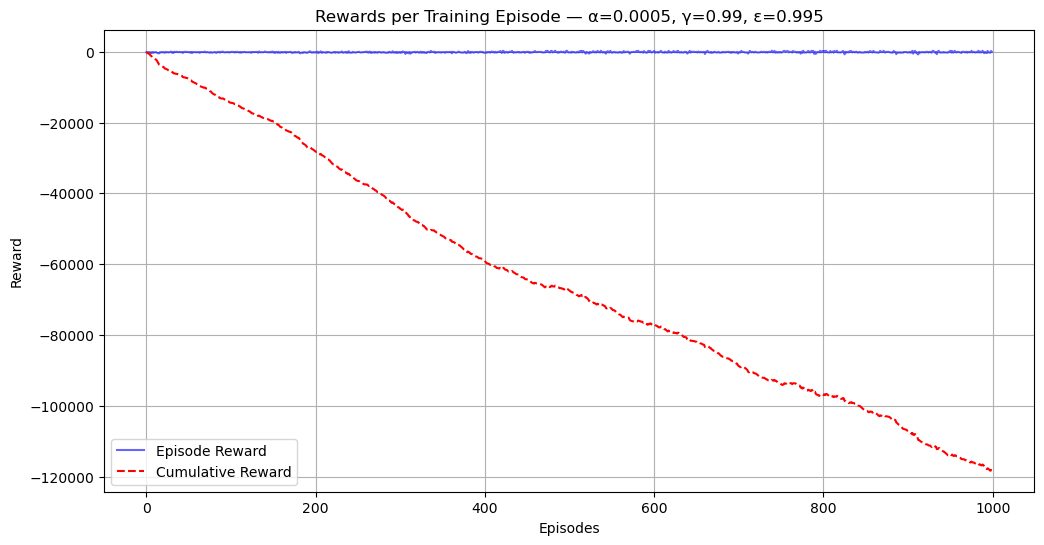

In [13]:
# Calculate cumulative rewards
import numpy as np
cumulative_rewards = np.cumsum(rewards)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Episode Reward', color='blue', alpha=0.6)
plt.plot(cumulative_rewards, label='Cumulative Reward', color='red', linestyle='--', linewidth=1.5)
plt.title(f"Rewards per Training Episode — α={LR}, γ={GAMMA}, ε={EPS_DECAY}")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()

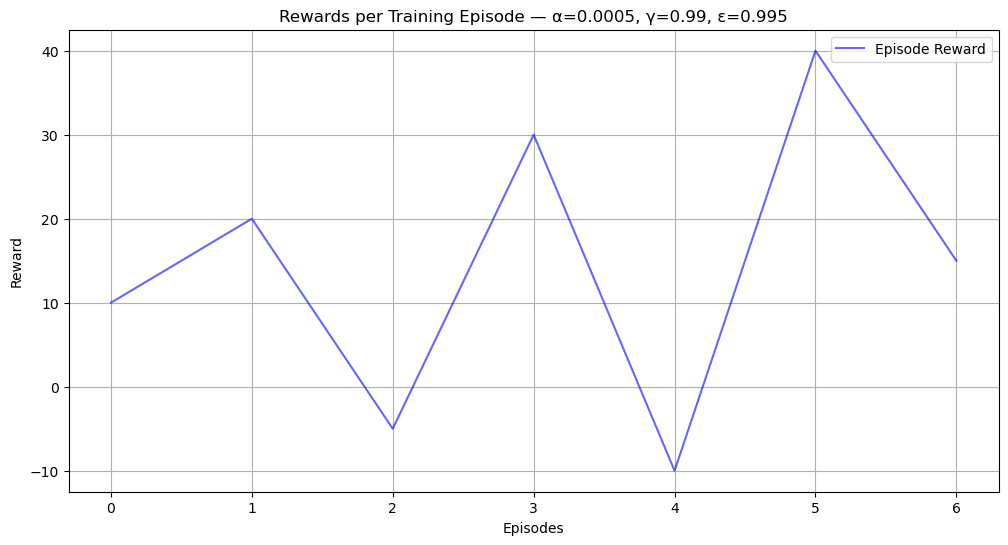

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Episode Reward', color='blue', alpha=0.6)  # Plot with label
plt.title(f"Rewards per Training Episode — α={LR}, γ={GAMMA}, ε={EPS_DECAY}")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()  
plt.show()

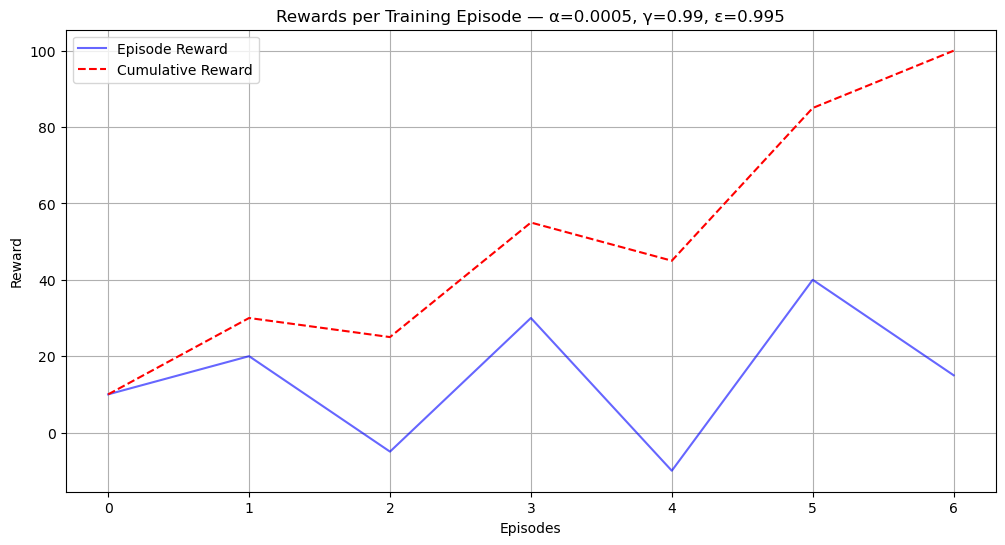

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Example rewards data
rewards = [10, 20, -5, 30, -10, 40, 15]  # Replace with your actual rewards

# Calculate cumulative rewards
cumulative_rewards = np.cumsum(rewards)

# Plotting
plt.figure(figsize=(12, 6))

# Plot episode rewards
plt.plot(rewards, label='Episode Reward', color='blue', alpha=0.6)

# Plot cumulative rewards
plt.plot(cumulative_rewards, label='Cumulative Reward', color='red', linestyle='--', linewidth=1.5)

# Add titles and labels
plt.title(f"Rewards per Training Episode — α={LR}, γ={GAMMA}, ε={EPS_DECAY}")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()  # Add a legend to differentiate between the two plots

# Show the plot
plt.show()


In [17]:
!pip install moviepy

Defaulting to user installation because normal site-packages is not writeable
  Using cached moviepy-2.1.1-py3-none-any.whl.metadata (6.9 kB)
  Using cached imageio_ffmpeg-0.5.1-py3-none-win_amd64.whl.metadata (1.6 kB)
  Using cached proglog-0.1.10-py3-none-any.whl.metadata (639 bytes)
Using cached moviepy-2.1.1-py3-none-any.whl (123 kB)
Using cached imageio_ffmpeg-0.5.1-py3-none-win_amd64.whl (22.6 MB)
Using cached proglog-0.1.10-py3-none-any.whl (6.1 kB)


In [42]:
import base64
import glob
import io
import os
from gym.wrappers.record_video import RecordVideo
from IPython.display import HTML, display
import gym

# Function to display the video with reduced playback speed
def show_video_slow(video_path, playback_speed=0.5):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data=f'''
        <video alt="test" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        <script>
            const videos = document.getElementsByTagName('video');
            for (const video of videos) {{
                video.playbackRate = {playback_speed};
            }}
        </script>
    '''))

# Function to record the video of the agent interacting with the environment
def record_agent_interaction(agent, env_name, video_dir):
    """Record a video of the agent interacting with the environment."""
    env = gym.make(env_name, render_mode="rgb_array") 
    env = RecordVideo(env, video_dir, episode_trigger=lambda x: True)  # Record all episodes
    state, _ = env.reset(seed=42)
    done = False

    while not done:
        # Agent selects an action
        action = agent.act(state)

        # Environment responds to the action
        result = env.step(action)
        if len(result) == 5:  # New Gym API
            next_state, reward, done, truncated, info = result
            done = done or truncated  # Combine `done` and `truncated`
        else:  # Older Gym API
            next_state, reward, done, info = result

        state = next_state

    env.close()

# Dummy Agent class for demonstration
class Agent:
    def __init__(self, state_size, action_size, seed):
        pass

    def act(self, state):
        # Randomly select an action (replace with your model's logic)
        return env.action_space.sample()

# Define the agent and environment
agent = Agent(state_size=8, action_size=4, seed=0)
env_name = 'LunarLander-v2'

# Record and display video
video_dir = "video"
os.makedirs(video_dir, exist_ok=True)

record_agent_interaction(agent, env_name, video_dir)
mp4_list = glob.glob(f"{video_dir}/*.mp4")

if mp4_list:
    show_video_slow(mp4_list[0], playback_speed=0.5)  # Set playback speed to 0.5x
else:
    print("No video recorded.")


MoviePy - Building video C:\Users\bless\video\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\bless\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\bless\video\rl-video-episode-0.mp4


In [48]:
import base64
import glob
import io
import os
from gym.wrappers.record_video import RecordVideo
from IPython.display import HTML, display
import gym
import numpy as np

# Function to display the video with reduced speed
def display_video_slow(video_path, playback_speed=0.5):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data=f'''
        <video alt="test" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        <script>
            const videos = document.getElementsByTagName('video');
            for (const video of videos) {{
                video.playbackRate = {playback_speed};
            }}
        </script>
    '''))

# Function to record a successful episode
def record_successful_landing(model, env_name, reward_threshold=200):
    os.makedirs("video", exist_ok=True)  # Ensure the video directory exists
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, "video", episode_trigger=lambda x: True)

    successful_episode = False
    while not successful_episode:
        state, _ = env.reset() if isinstance(env.reset(), tuple) else env.reset()
        total_reward = 0
        done = False

        while not done:
            action = np.argmax(model.predict(state[np.newaxis], verbose=0))  # Predict action
            result = env.step(action)
            if len(result) == 5:  # Handle new Gym API
                next_state, reward, done, truncated, info = result
                done = done or truncated
            else:
                next_state, reward, done, info = result

            # Reward shaping for central landing
            if abs(state[0]) < 0.1:
                reward += 10
            if abs(state[1]) < 0.1:
                reward += 10

            total_reward += reward
            state = next_state

        # Check if the agent landed safely with a reward above the threshold
        if total_reward >= reward_threshold:
            successful_episode = True
            print(f"Successful landing recorded with total reward: {total_reward}")
        else:
            print(f"Retrying... Last episode reward: {total_reward}")

    env.close()

# Record and display a successful landing
#record_successful_landing(main_model, "LunarLander-v2", reward_threshold=200)

# Find and display the video
video_path = glob.glob("video/*.mp4")[0]  # Find the first video in the folder
display_video_slow(video_path, playback_speed=0.5)  # Display the video at 0.5x speed
